In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from raw_utils import *
from alignment import *
import rawpy
from dataset_navigation import get_image_paths

In [9]:
paths = get_image_paths()
print(paths.keys())

# 330.810.480

dict_keys(['filter_long_exp', 'long_exp', 'short_exp'])


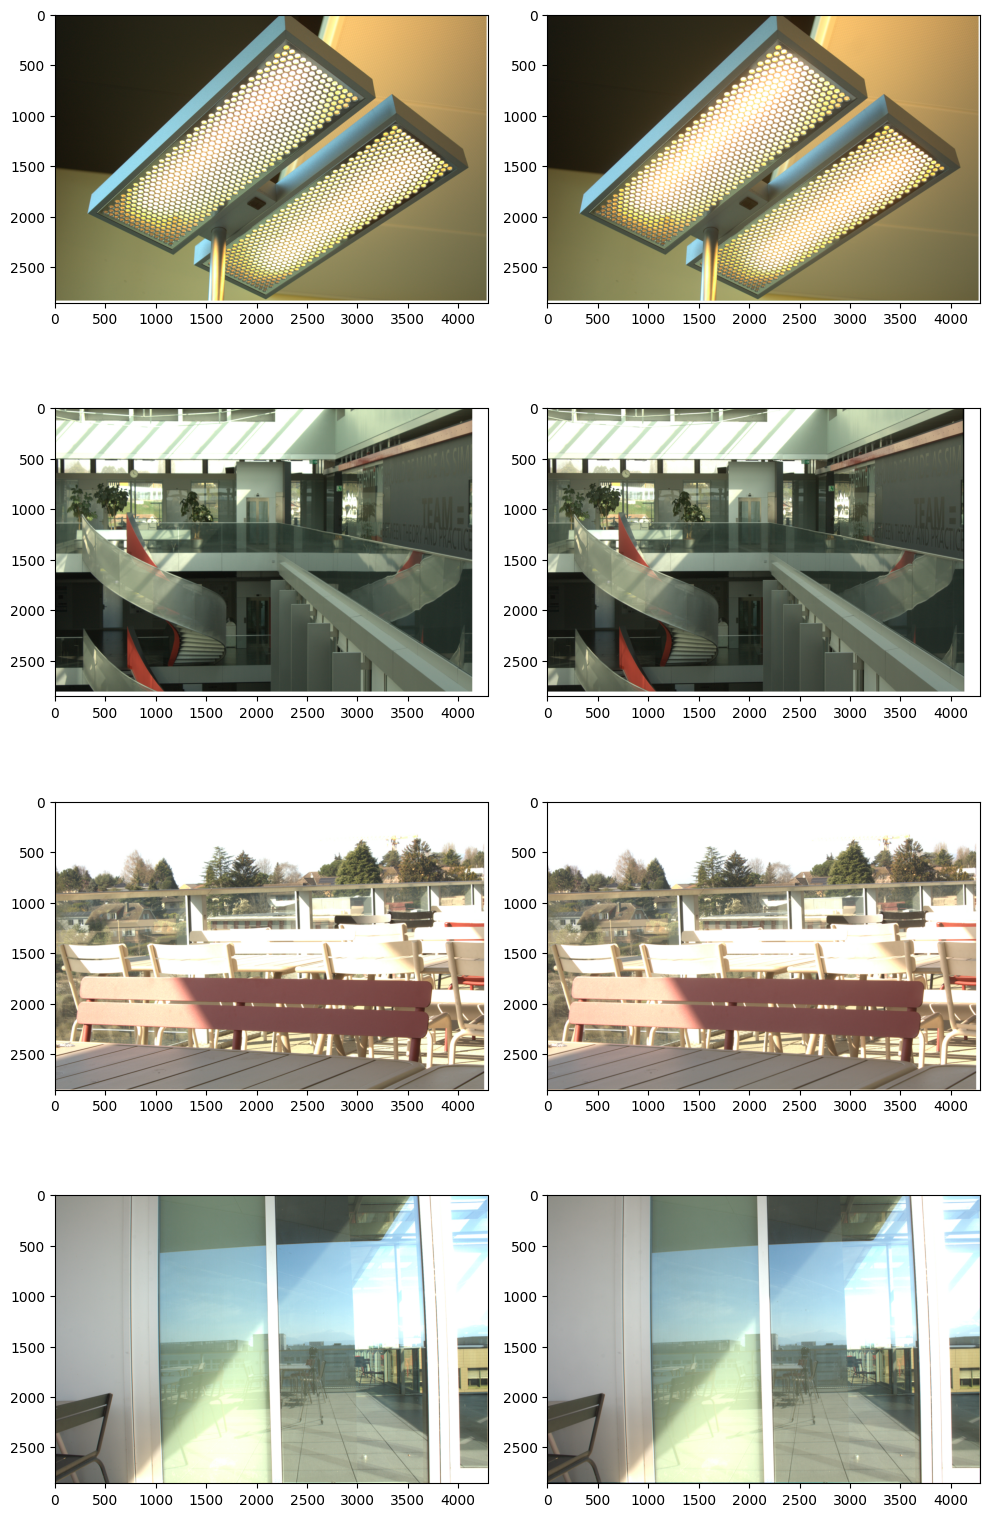

In [3]:

n = 4
fig, axs = plt.subplots(n,2, figsize=(10,4*n))
unfiltered_paths = paths['long_exp']
filtered_paths = paths['filter_long_exp']
for i in range(n):
    # unfiltered = rawpy.imread(unfiltered_paths[i]).postprocess()
    unfiltered, filtered = align_and_crop_raw_images(unfiltered_paths[i], filtered_paths[i])
    unfiltered_postprocessed = unfiltered['raw'].postprocess()
    filtered_postprocessed = filtered['raw'].postprocess()
    axs[i,0].imshow(unfiltered_postprocessed)
    # filtered = rawpy.imread(filtered_paths[i]).postprocess()
    axs[i,1].imshow(filtered_postprocessed)
fig.tight_layout()
plt.show()



# return_original = {"raw": original_image_raw, "mosaic_array": original_image_array, "channels": cropped_original}
# return_aligned = {"raw": aligned_image_raw, "mosaic_array": aligned_image_array, "channels": cropped_aligned}

# return return_original, return_aligned

In [3]:


def compute_local_variance_single_channel(image, kernel_size=5):
    image = image.astype(np.float64)
    # cv2 blur calculates local mean using a box filter
    mean = cv2.blur(image, (kernel_size, kernel_size))
    mean_sq = cv2.blur(image**2, (kernel_size, kernel_size))
    variance = mean_sq - mean**2
    return variance

def compute_local_variance(image, kernel_size=5):
    R_variance = compute_local_variance_single_channel(image[:, :, 0], kernel_size)
    G1_variance = compute_local_variance_single_channel(image[:, :, 1], kernel_size)
    B_variance = compute_local_variance_single_channel(image[:, :, 2], kernel_size)
    G2_variance = compute_local_variance_single_channel(image[:, :, 3], kernel_size)

    return np.stack((R_variance, G1_variance, B_variance, G2_variance), axis=2)

def compute_local_mean_single_channel(image, kernel_size=5):
    image = image.astype(np.float64)
    # cv2 blur calculates local mean using a box filter
    mean = cv2.blur(image, (kernel_size, kernel_size))
    return mean

def compute_local_mean(image, kernel_size=5):
    R_variance = compute_local_mean_single_channel(image[:, :, 0], kernel_size)
    G1_variance = compute_local_mean_single_channel(image[:, :, 1], kernel_size)
    B_variance = compute_local_mean_single_channel(image[:, :, 2], kernel_size)
    G2_variance = compute_local_mean_single_channel(image[:, :, 3], kernel_size)

    return np.stack((R_variance, G1_variance, B_variance, G2_variance), axis=2)

In [4]:


def create_array_per_pair(image, variance_difference):
    image = image.flatten()
    variance_difference = variance_difference.flatten()
    if image.shape != variance_difference.shape:
        raise ValueError("Inputs must have the same shape after flattening.")
    paired_array = np.stack((image, variance_difference), axis=1)
    return paired_array

def average_y_per_x(paired_array, threshold=0):
    x = paired_array[:, 0]
    y = paired_array[:, 1]
    unique_x, inverse_indices = np.unique(x, return_inverse=True)
    sum_y = np.bincount(inverse_indices, weights=y)
    count_y = np.bincount(inverse_indices)
    avg_y = sum_y / count_y
    # Apply threshold
    mask = count_y >= threshold
    filtered_x = unique_x[mask]
    filtered_avg_y = avg_y[mask]
    return np.stack((filtered_x, filtered_avg_y), axis=1)

def average_y_per_x_binned(paired_array, num_bins=100, threshold=0):
    x = paired_array[:, 0]
    y = paired_array[:, 1]

    # Create bins
    x_min, x_max = x.min(), x.max()
    bins = np.linspace(x_min, x_max, num_bins + 1)

    # Assign each x to a bin
    bin_indices = np.digitize(x, bins) - 1  # shift to 0-based index

    # Remove out-of-range values
    valid_mask = (bin_indices >= 0) & (bin_indices < num_bins)
    bin_indices = bin_indices[valid_mask]
    y = y[valid_mask]

    # Compute average y per bin
    sum_y = np.bincount(bin_indices, weights=y, minlength=num_bins)
    count_y = np.bincount(bin_indices, minlength=num_bins)
    avg_y = np.divide(sum_y, count_y, out=np.zeros_like(sum_y), where=count_y > 0)

    # Apply threshold
    mask = count_y >= threshold
    bin_centers = (bins[:-1] + bins[1:]) / 2
    filtered_x = bin_centers[mask]
    filtered_avg_y = avg_y[mask]

    return np.stack((filtered_x, filtered_avg_y), axis=1)



In [4]:
from dataset_navigation import get_image_paths
from tqdm import tqdm
paths_dict = get_image_paths()
# n = 2
# diffused_image_paths = paths_dict['filter_long_exp'][:n]
# clear_image_paths = paths_dict['long_exp'][:n]

diffused_image_paths = paths_dict['filter_long_exp']
clear_image_paths = paths_dict['long_exp']

pixels_r = np.zeros(0)
pixel_to_variance_difference_r = np.zeros((0,2))
pixel_to_mean_difference_r = np.zeros((0,2))
pixel_to_variance_difference_normalized_r = np.zeros((0,2))
pixel_to_variance_clear_r = np.zeros((0,2))
pixel_to_variance_diffused_r = np.zeros((0,2))

for diffused_image_path, clear_image_path in tqdm(zip(diffused_image_paths, clear_image_paths), total=len(diffused_image_paths)):
    clear, diffused = align_and_crop_raw_images(clear_image_path, diffused_image_path)
    clear_channels = clear['channels']
    diffused_channels = diffused['channels']
    clear_variance = compute_local_variance(clear_channels)
    diffused_variance = compute_local_variance(diffused_channels)
    clear_mean = compute_local_mean(clear_channels)
    diffused_mean = compute_local_mean(diffused_channels)
    mean_difference = (diffused_mean - clear_mean)
    variance_difference_normalized = (diffused_variance - clear_variance ) / ( clear_variance + diffused_variance + 1e-8)
    variance_difference = (diffused_variance - clear_variance)
    pixels_r = np.append(pixels_r, clear_channels[:,:,0].flatten())
    pixel_to_mean_difference_r = np.append(pixel_to_mean_difference_r, create_array_per_pair(clear_channels[:,:,0], mean_difference[:,:,0]), axis=0)
    pixel_to_variance_difference_r = np.append(pixel_to_variance_difference_r, create_array_per_pair(clear_channels[:,:,0], variance_difference[:,:,0]), axis=0)
    pixel_to_variance_difference_normalized_r = np.append(pixel_to_variance_difference_normalized_r, create_array_per_pair(clear_channels[:,:,0], variance_difference_normalized[:,:,0]), axis=0)
    pixel_to_variance_clear_r = np.append(pixel_to_variance_clear_r, create_array_per_pair(clear_channels[:,:,0], clear_variance[:,:,0]), axis=0)
    pixel_to_variance_diffused_r = np.append(pixel_to_variance_diffused_r, create_array_per_pair(clear_channels[:,:,0], diffused_variance[:,:,0]), axis=0)
print(pixel_to_variance_difference_r.shape)

  1%|▏         | 1/77 [00:04<05:46,  4.56s/it]


KeyboardInterrupt: 

In [5]:
def plot_scatter(paired_array, ax, xlabel="", ylabel="", title=""):
    x = paired_array[:, 0]
    y = paired_array[:, 1]
    ax.scatter(x, y, s=1, alpha=0.8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

def plot_avg_variance_difference_by_pixel_1_channel(variance_difference_by_pixel_compared_to_original, threshold=0, ax=None):
    # avg_variance_by_pixel_compared_to_original = average_y_per_x(variance_difference_by_pixel_compared_to_original, threshold=threshold)
    avg_variance_by_pixel_compared_to_original = average_y_per_x_binned(variance_difference_by_pixel_compared_to_original, num_bins=500, threshold=threshold)
    if ax is None:
        fig, ax = plt.subplots()
    plot_scatter(avg_variance_by_pixel_compared_to_original, ax, "Pixel intensity", "Avg variance difference", "Avg variance difference by pixel intensity")

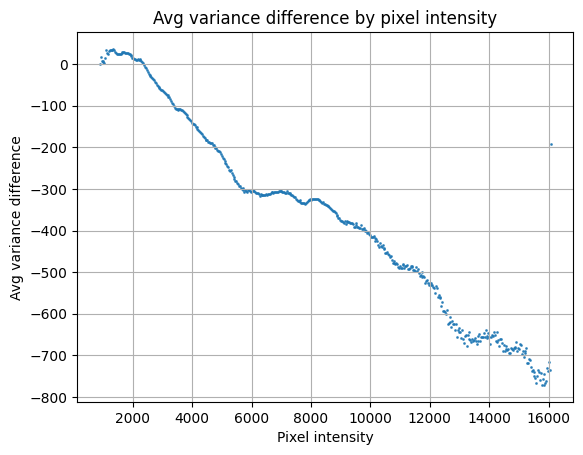

In [7]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_mean_difference_r)


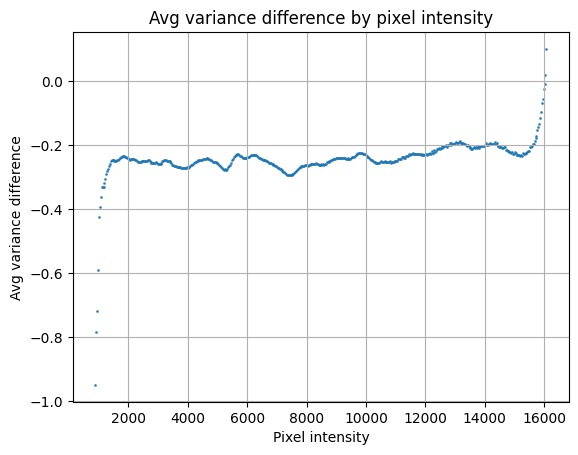

In [8]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_difference_normalized_r)

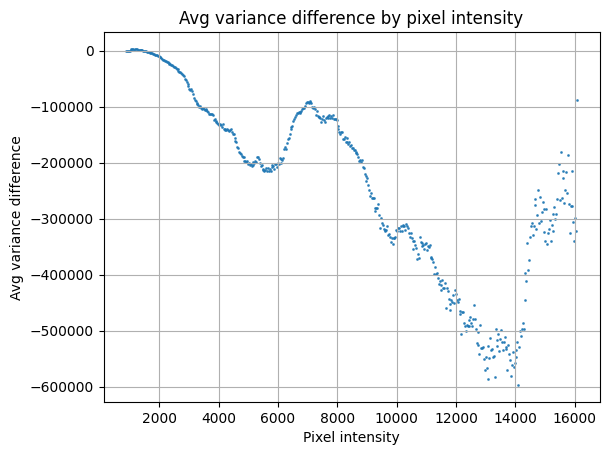

In [9]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_difference_r)


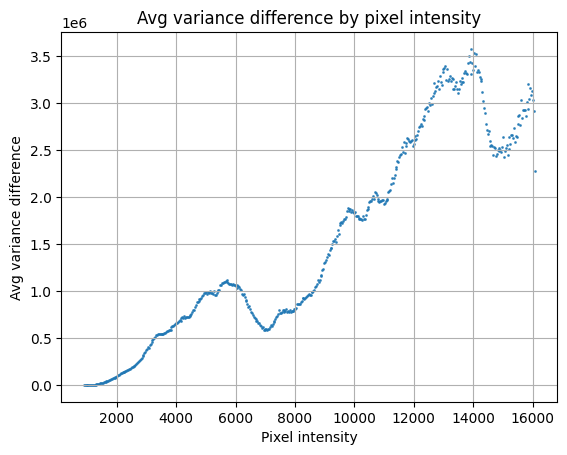

In [10]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_clear_r)

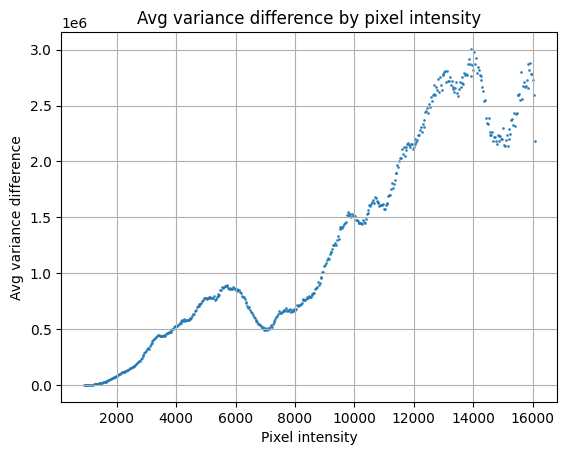

In [11]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_diffused_r)


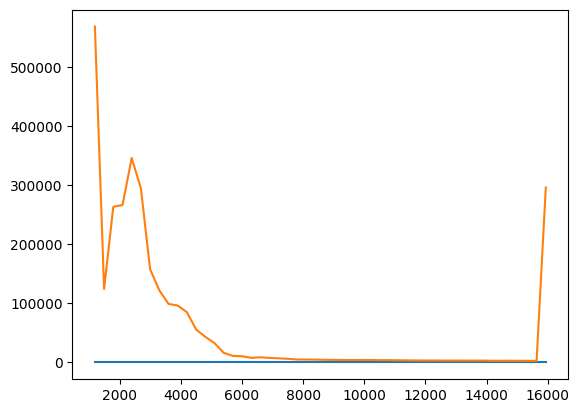

In [47]:

# simply plot avg brightness histogram
num_bins = 50

# print(np.allclose(pixel_to_variance_difference_r[:, 0], pixels_r))

counts, bin_edges = np.histogram(pixel_to_variance_difference_r[:, 0], bins=num_bins)
# counts, bin_edges = np.histogram(pixels_r, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
inv_counts = np.where(counts != 0, 1 / counts, 0)

# Plot as points
plt.plot(bin_centers, inv_counts)
plt.plot(bin_centers, counts)
# plt.hist(pixel_to_variance_difference_r[:, 0], bins=num_bins)
# plt.plot(bins, hist)
plt.show()

## Simple example on a single image
In this example you can just about see the inverse relationship between the number of pixel of a certain brightness level and the variance around that brightness level.
It is however very noisy as we are only processing a single image. This example uses simple to understand code.
In the next sample we process all the images, using slightly more complex functions to calculate the averages for faster processing. 

In [45]:
# Load image and flatten
path_to_raw = './dataset_raw/long_exp/photo_2 (2).CR2'
red_channel = pack_raw(rawpy.imread(path_to_raw))[:,:,0]
image_flat = red_channel.flatten()
image_flat = image_flat[image_flat != image_flat.max()]

# Compute avg variance per pixel brightness level
variances = compute_local_variance_single_channel(red_channel, kernel_size=5)
variances_flat = variances.flatten()

brightness_variances = {}

for i in range(image_flat.max()+1):
    brightness_variances[np.uint16(i)] = []
for i in range(len(image_flat)):
    brightness = image_flat[i]
    variance = variances_flat[i]
    brightness_variances[brightness].append(variance)

brightness_avg_variances = {}
brightness_values = []
for brightness, variances in brightness_variances.items():
    if len(variances) == 0: continue
    brightness_avg_variances[brightness] = sum(variances)/len(variances)
    
# Plot graphs
num_bins = 50

counts, bin_edges = np.histogram(image_flat, bins=num_bins)
# counts, bin_edges = np.histogram(pixels_r, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
inv_counts = np.where(counts != 0, 1 / counts, 0)

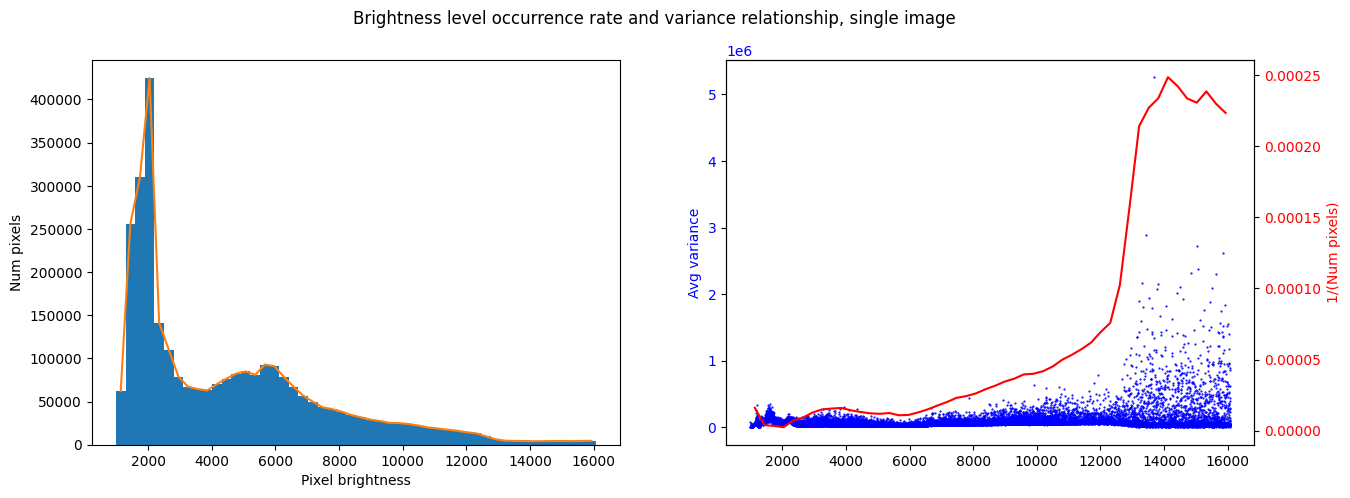

In [46]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Brightness level occurrence rate and variance relationship, single image")
ax[0].hist(image_flat, bins=num_bins, log=False)
ax[0].plot(bin_centers, counts)
ax[0].set_ylabel("Num pixels")
ax[0].set_xlabel("Pixel brightness")
ax1_twin = ax[1].twinx()
ax1_twin.plot(bin_centers, inv_counts, color='red')
ax1_twin.set_ylabel("1/(Num pixels)", color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax[1].scatter(list(brightness_avg_variances.keys()), list(brightness_avg_variances.values()), s=0.3, color='blue')
ax[1].tick_params(axis='y', labelcolor='blue')
ax[1].set_ylabel("Avg variance", color='blue')
ax1_twin.set_xlabel("Pixel brightness")

plt.show()

## Same idea but for all image concatenated together for a better converged example
Here we process all the images in our dataset, we see that the relationship becomes a lot clearer.

In [54]:

from dataset_navigation import get_image_paths
from raw_utils import pack_raw
from tqdm import tqdm
paths_dict = get_image_paths()
# n = 2
# diffused_image_paths = paths_dict['filter_long_exp'][:n]
# clear_image_paths = paths_dict['long_exp'][:n]

clear_image_paths = paths_dict['long_exp']
pixel_to_variance_clear_r = np.zeros((0,2))

for clear_image_path in tqdm(clear_image_paths, total=len(clear_image_paths)):
    clear_channels = pack_raw(rawpy.imread(clear_image_path))    
    clear_variance = compute_local_variance(clear_channels)
    pixel_to_variance_clear_r = np.append(pixel_to_variance_clear_r, create_array_per_pair(clear_channels[:,:,0], clear_variance[:,:,0]), axis=0)


{'photo_33.CR2', 'photo_8.CR2'}


100%|██████████| 44/44 [00:33<00:00,  1.30it/s]


In [42]:

images_flat = pixel_to_variance_clear_r[:, 0]
variances_flat = pixel_to_variance_clear_r[:, 1]
# Here we can't use the dictionary approach anymore because it is too slow to process all the pixels for all the images.
# Instead we use our complicated average_y_per_x function to calculate the pixel value for each 

# Minimum number of locations of a brightness level to be included in the statistics.
threshold = 0
avg_y_per_x = average_y_per_x(pixel_to_variance_clear_r, threshold=threshold)

num_bins = 100

counts, bin_edges = np.histogram(images_flat, bins=num_bins)
# counts, bin_edges = np.histogram(pixels_r, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
inv_counts = np.where(counts != 0, 1 / counts, 0)


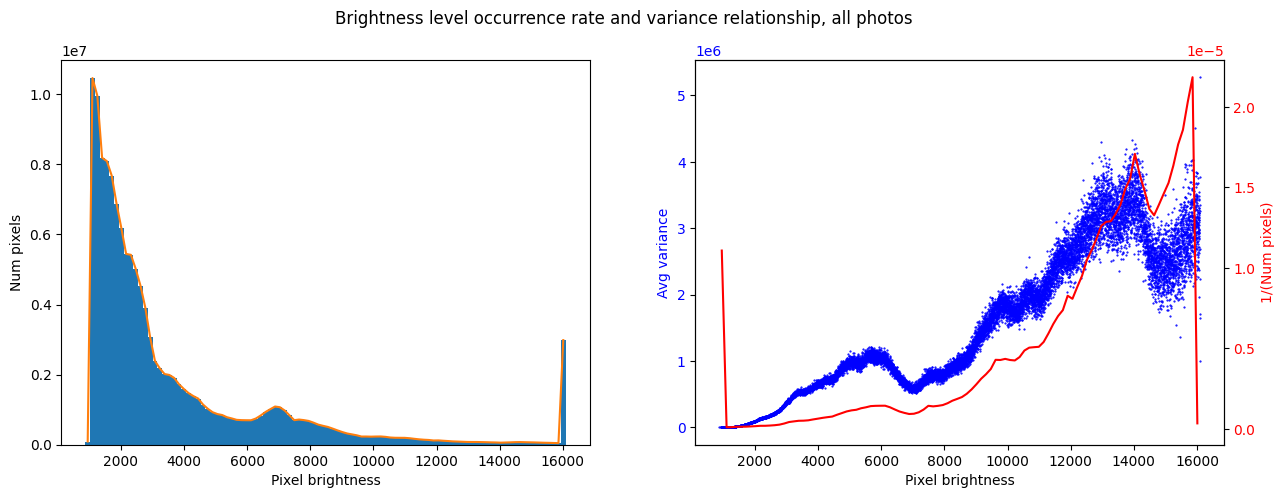

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Brightness level occurrence rate and variance relationship, all photos")
ax[0].hist(images_flat, bins=num_bins, log=False)
ax[0].plot(bin_centers, counts)
ax[0].set_ylabel("Num pixels")
ax[0].set_xlabel("Pixel brightness")
ax1_twin = ax[1].twinx()
ax1_twin.plot(bin_centers, inv_counts, color='red')
ax1_twin.set_ylabel("1/(Num pixels)", color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax[1].scatter(avg_y_per_x[:,0], avg_y_per_x[:,1], s=0.3, color='blue')
ax[1].tick_params(axis='y', labelcolor='blue')
ax[1].set_ylabel("Avg variance", color='blue')
ax[1].set_xlabel("Pixel brightness")
ax1_twin.set_xlabel("Pixel brightness")

plt.show()

## Use python module that is multi threaded


In [15]:
# import variance_brightness_analysis as vba
# brightness_to_variance_r = vba.get_brightness_to_variance()

In [11]:
threshold = 100
avg_y_per_x = average_y_per_x(brightness_to_variance_r, threshold=threshold)


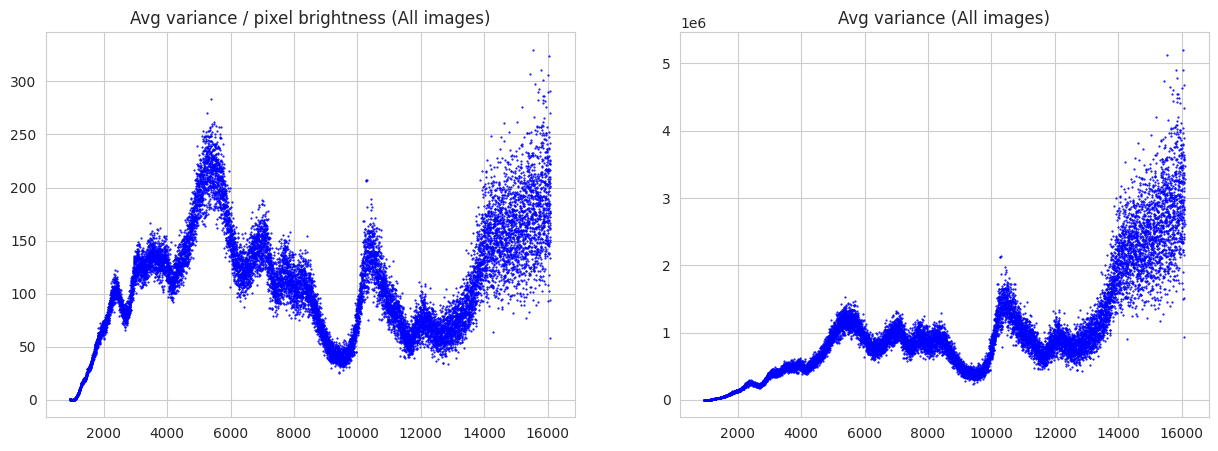

In [21]:
# Here we can't use the dictionary approach anymore because it is too slow to process all the pixels for all the images.
# Instead we use our complicated average_y_per_x function to calculate the pixel value for each 
# Remove outliers
avg_y_per_x_no_outliers = avg_y_per_x[avg_y_per_x[:, 1] < 8e6]
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(avg_y_per_x_no_outliers[:,0], avg_y_per_x_no_outliers[:,1]/avg_y_per_x_no_outliers[:,0], s=0.3, color='blue')
ax[0].set_title("Avg variance / pixel brightness (All images)")

ax[1].scatter(avg_y_per_x_no_outliers[:,0], avg_y_per_x_no_outliers[:,1], s=0.3, color='blue')
ax[1].set_title("Avg variance (All images)")
plt.show()

In [5]:
channel = 1 
brightness_to_variance_difference_r = vba.get_brightness_to_variance_difference(channel=0)
brightness_to_variance_difference_g1 = vba.get_brightness_to_variance_difference(channel=1)
brightness_to_variance_difference_b = vba.get_brightness_to_variance_difference(channel=2)
brightness_to_variance_difference_g2 = vba.get_brightness_to_variance_difference(channel=3)


  0%|          | 0/77 [00:09<?, ?it/s]
Process ForkProcess-13:
Process ForkProcess-22:
Process ForkProcess-19:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt

During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._

KeyboardInterrupt: 

### Look at variance difference

In [13]:
print(brightness_to_variance_difference_r[:,0].min())
print(brightness_to_variance_difference_r[:,0].max())
print(brightness_to_variance_difference_r[:,1].min())
print(brightness_to_variance_difference_r[:,1].max())
print(brightness_to_variance_difference_r.shape)

0.02318694442510605
0.9814756512641907
-0.1903930194053104
0.15590303939419436
(202157186, 2)


In [8]:
threshold = 100
avg_y_per_x = average_y_per_x(brightness_to_variance_difference_single_channel, threshold=threshold)

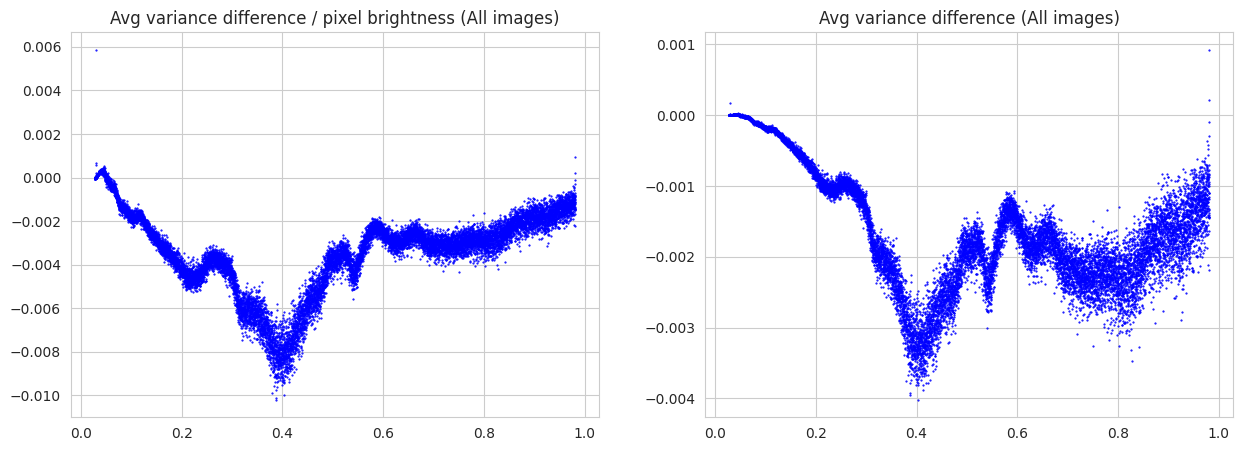

In [9]:
# Here we can't use the dictionary approach anymore because it is too slow to process all the pixels for all the images.
# Instead we use our complicated average_y_per_x function to calculate the pixel value for each 
# Remove outliers
avg_y_per_x_no_outliers = avg_y_per_x#[avg_y_per_x[:, 1] < 8e6]

avg_y_per_x_no_outliers = avg_y_per_x[np.abs(avg_y_per_x[:, 1]) < 2e6]
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(avg_y_per_x_no_outliers[:,0], avg_y_per_x_no_outliers[:,1]/avg_y_per_x_no_outliers[:,0], s=0.3, color='blue')
ax[0].set_title("Avg variance difference / pixel brightness (All images)")

ax[1].scatter(avg_y_per_x_no_outliers[:,0], avg_y_per_x_no_outliers[:,1], s=0.3, color='blue')
ax[1].set_title("Avg variance difference (All images)")
plt.show()

In [35]:
# fit a polynomial to the data
from scipy.optimize import curve_fit
# Use a polynomial of a high degree
def poly_func(x, *coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))
# Fit the polynomial to the data
degree = 7
coeffs, _ = curve_fit(poly_func, avg_y_per_x_no_outliers[:,0], avg_y_per_x_no_outliers[:,1], p0=[1]*degree)
# Generate x values for the fitted curve
x_fit = np.linspace(avg_y_per_x_no_outliers[:,0].min(), avg_y_per_x_no_outliers[:,0].max(), 100)
# Calculate the fitted y values
y_fit = poly_func(x_fit, *coeffs)
# Plot the original data and the fitted curve
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(avg_y_per_x_no_outliers[:,0], avg_y_per_x_no_outliers[:,1]/avg_y_per_x_no_outliers[:,0], s=0.3, color='blue')
ax[0].set_title("Avg variance difference / pixel brightness (All images)")
ax[0].plot(x_fit, y_fit/x_fit, color='red')
ax[1].scatter(avg_y_per_x_no_outliers[:,0], avg_y_per_x_no_outliers[:,1], s=0.3, color='blue')
ax[1].set_title("Avg variance difference (All images)")
ax[1].plot(x_fit, y_fit, color='red')
plt.show()



NameError: name 'avg_y_per_x_no_outliers' is not defined

Polynomial coefficients: [ 2.94554410e+05 -3.92608548e+02  1.87221132e-01 -5.09427571e-05
  6.82300323e-09 -4.20293146e-13  9.51748215e-18]


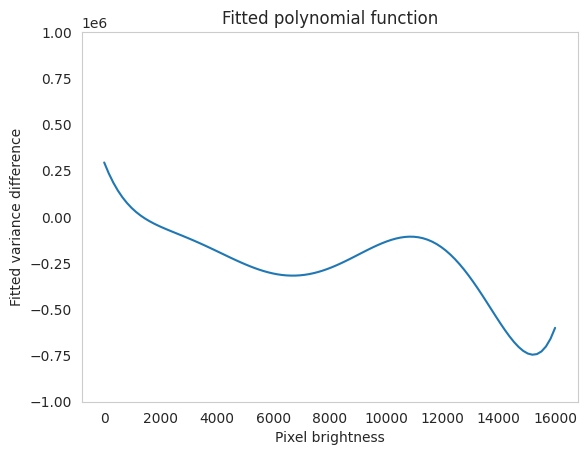

In [37]:
# print the coefficients
print("Polynomial coefficients:", coeffs)
def fitted_func(x):
    coeffs = [ 2.94554410e+05, -3.92608548e+02,  1.87221132e-01, -5.09427571e-05,
              6.82300323e-09,-4.20293146e-13, 9.51748215e-18]
    return sum(c * x**i for i, c in enumerate(coeffs))

def fitted_func(x):
    coeffs = [2.94554410e+05, -3.92608548e+02, 1.87221132e-01, -5.09427571e-05,
              6.82300323e-09, -4.20293146e-13, 9.51748215e-18]
    return np.polyval(coeffs[::-1], x)

# Try the fitted function
x_test = np.linspace(0, 16000, 100)
y_test = fitted_func(x_test)
# set the y axis range to be the same as the original data
plt.ylim(-1e6, 1e6)
plt.plot(x_test, y_test)
plt.xlabel("Pixel brightness")
plt.ylabel("Fitted variance difference")
plt.title("Fitted polynomial function")
plt.grid()
plt.show()


## Compare different color channels


In [10]:
import variance_brightness_analysis as vba

def get_avg_y_per_x_for_channel(channel):
    brightness_to_variance_difference_r = vba.get_brightness_to_variance_difference(channel=channel)
    threshold = 10
    avg_y_per_x = average_y_per_x(brightness_to_variance_difference_r, threshold=threshold)
    return avg_y_per_x

In [123]:

channel_to_plt_color = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'purple'
}

avg_y_per_x_r = get_avg_y_per_x_for_channel(0)
avg_y_per_x_g1 = get_avg_y_per_x_for_channel(1)
avg_y_per_x_b = get_avg_y_per_x_for_channel(2)
avg_y_per_x_g2 = get_avg_y_per_x_for_channel(3)


 16%|█▌        | 12/77 [00:11<01:00,  1.08it/s]


KeyboardInterrupt: 

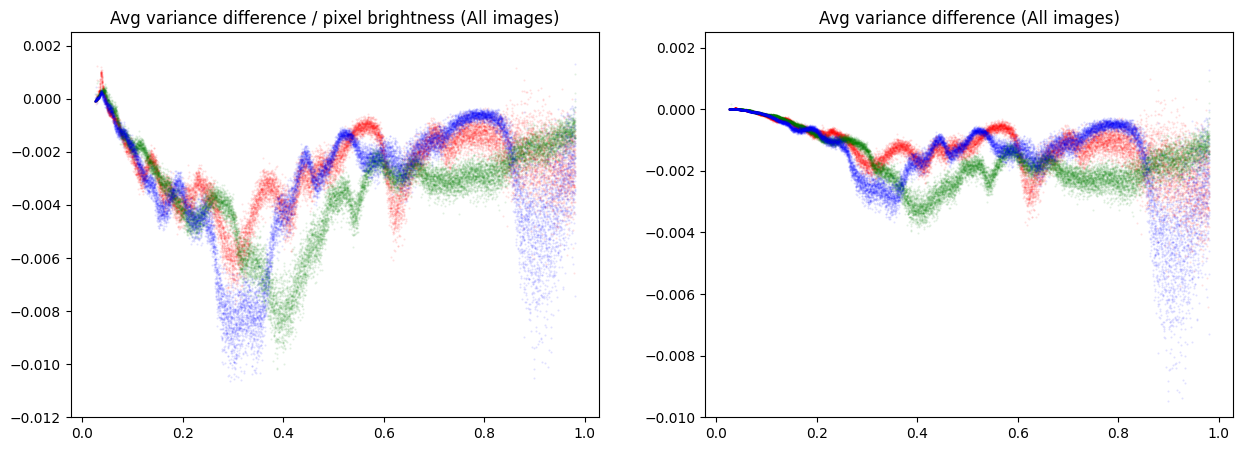

In [25]:
channel_results = [avg_y_per_x_r, avg_y_per_x_g1, avg_y_per_x_b, avg_y_per_x_g2]
fig, ax = plt.subplots(1,2, figsize=(15,5))
for channel in range(3):
    avg_y_per_x = channel_results[channel]
    ax[0].scatter(avg_y_per_x[:,0], avg_y_per_x[:,1]/avg_y_per_x[:,0], s=0.3, color=channel_to_plt_color[channel], label=f"Channel {channel}", alpha=0.1)
    ax[0].set_title(f"Avg variance difference / pixel brightness (All images)")
    ax[0].set_ylim(-0.012, 0.0025)
    ax[1].scatter(avg_y_per_x[:,0], avg_y_per_x[:,1], s=0.3, color=channel_to_plt_color[channel], label=f"Channel {channel}", alpha=0.1)
    ax[1].set_title(f"Avg variance difference (All images)")
    ax[1].set_ylim(-0.01, 0.0025)
plt.show()

In [ ]:
# Save the different channels to a file
for idx, channel_result in enumerate(channel_results):
    np.save(f"avg_variance_difference_per_brightness_channel_{idx}.npy", channel_result)

In [124]:
# Load the different channels from a file
avg_y_per_x_r = np.load("avg_variance_difference_per_brightness_channel_0.npy")
avg_y_per_x_g1 = np.load("avg_variance_difference_per_brightness_channel_1.npy")
avg_y_per_x_b = np.load("avg_variance_difference_per_brightness_channel_2.npy")
avg_y_per_x_g2 = np.load("avg_variance_difference_per_brightness_channel_3.npy")


In [166]:

from scipy.interpolate import UnivariateSpline

# assume x and y are your 1D arrays of length ~16 000
# e.g. x = np.linspace(0, 10, 16000); y = f(x) + noise

# 1) choose a spline degree k (3 = cubic) and smoothing factor s.
#    s controls how “wiggly” the spline is:
#    - s=0 → exact interpolation
#    - larger s → smoother fit
def fit_spline(avg_y_per_x_r, smoothing_factor=2e-3):
    spl = UnivariateSpline(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], s=smoothing_factor, k=5)
    return spl



In [86]:

# Fit the spline to the data
spline_r = fit_spline(avg_y_per_x_r)
print("Found spline for channel 0")
spline_g1 = fit_spline(avg_y_per_x_g1)
print("Found spline for channel 1")
spline_b = fit_spline(avg_y_per_x_b)
print("Found spline for channel 2")
spline_g2 = fit_spline(avg_y_per_x_g2)
print("Found spline for channel 3")




Found spline for channel 0
Found spline for channel 1
Found spline for channel 2
Found spline for channel 3


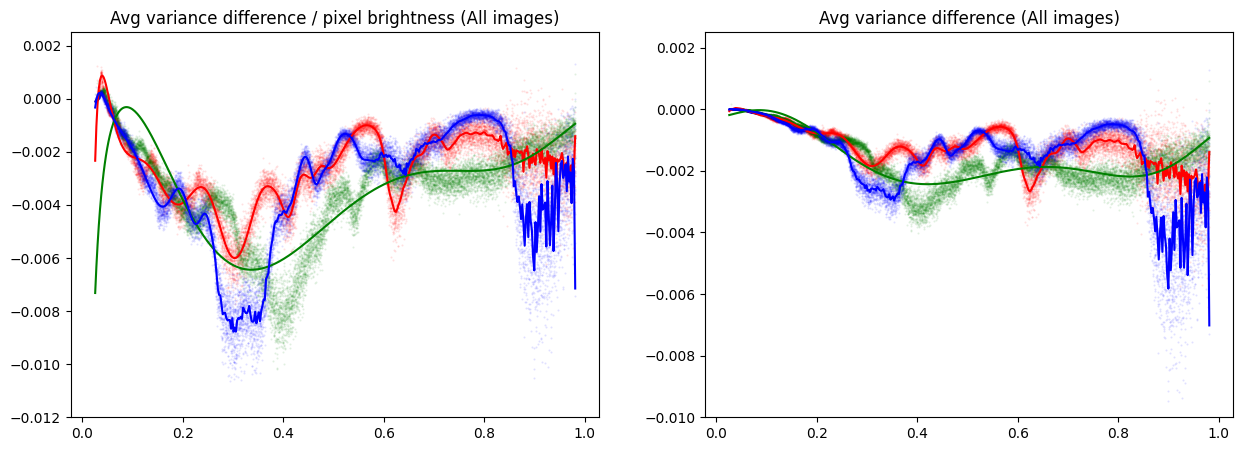

In [87]:
# Plot the original data and the fitted curve
fig, ax = plt.subplots(1,2, figsize=(15,5))
x_fit = np.linspace(avg_y_per_x_r[:,0].min(), avg_y_per_x_r[:,0].max(), 400)
y_fit_r = spline_r(x_fit)
y_fit_g1 = spline_g1(x_fit)
y_fit_b = spline_b(x_fit)
y_fit_g2 = spline_g2(x_fit)

ax[0].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1]/avg_y_per_x_r[:,0], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[0].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1]/avg_y_per_x_g1[:,0], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[0].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1]/avg_y_per_x_b[:,0], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[0].plot(x_fit, y_fit_r/x_fit, color='red')
ax[0].plot(x_fit, y_fit_g1/x_fit, color='green')
ax[0].plot(x_fit, y_fit_b/x_fit, color='blue')
ax[0].set_title("Avg variance difference / pixel brightness (All images)")
ax[0].set_ylim(-0.012, 0.0025)
ax[1].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[1].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[1].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[1].plot(x_fit, y_fit_r, color='red')
ax[1].plot(x_fit, y_fit_g1, color='green')
ax[1].plot(x_fit, y_fit_b, color='blue')
ax[1].set_title("Avg variance difference (All images)")
ax[1].set_ylim(-0.01, 0.0025)
plt.show()


In [125]:
# Do running median on the data
from scipy.ndimage import median_filter
def running_median(x, y, size=5):
    # Create a new array to hold the smoothed values
    smoothed_y = np.zeros_like(y)
    
    # Apply the median filter to the y values
    smoothed_y = median_filter(y, size=size)
    
    return smoothed_y

In [162]:

# Apply running median to the data
window_size = 200
smoothed_y_r = avg_y_per_x_r.copy()
smoothed_y_r[:,1] = running_median(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], size=window_size)
smoothed_y_g1 = avg_y_per_x_g1.copy()
smoothed_y_g1[:,1] = running_median(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1], size=window_size)
smoothed_y_b = avg_y_per_x_b.copy()
smoothed_y_b[:,1] = running_median(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1], size=window_size)
smoothed_y_g2 = avg_y_per_x_g2.copy()
smoothed_y_g2[:,1] = running_median(avg_y_per_x_g2[:,0], avg_y_per_x_g2[:,1], size=window_size)


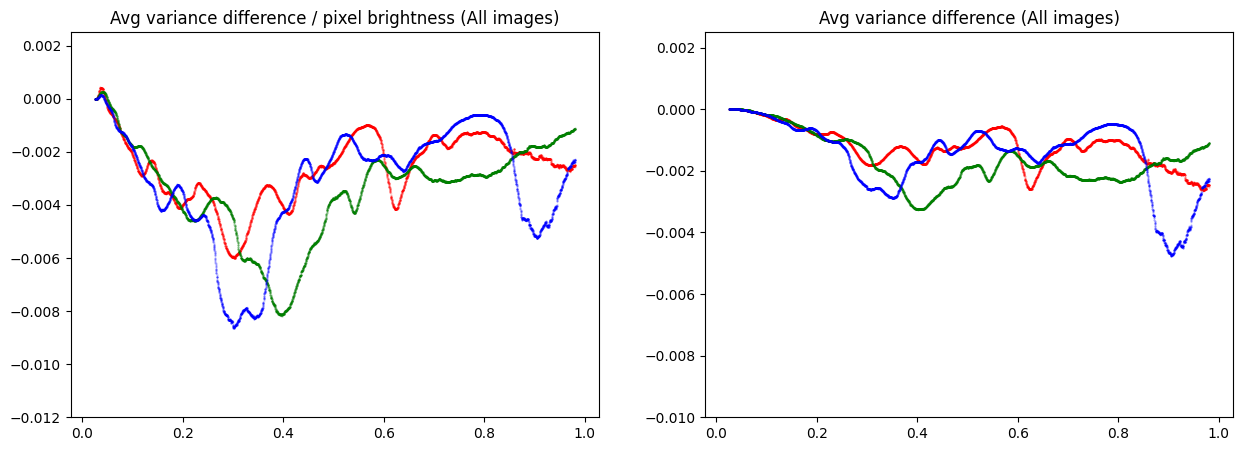

In [163]:
# Plot the smoothed data
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(smoothed_y_r[:,0], smoothed_y_r[:,1]/smoothed_y_r[:,0], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[0].scatter(smoothed_y_g1[:,0], smoothed_y_g1[:,1]/smoothed_y_g1[:,0], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[0].scatter(smoothed_y_b[:,0], smoothed_y_b[:,1]/smoothed_y_b[:,0], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[0].set_title("Avg variance difference / pixel brightness (All images)")
ax[0].set_ylim(-0.012, 0.0025)
ax[1].scatter(smoothed_y_r[:,0], smoothed_y_r[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[1].scatter(smoothed_y_g1[:,0], smoothed_y_g1[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[1].scatter(smoothed_y_b[:,0], smoothed_y_b[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[1].set_title("Avg variance difference (All images)")
ax[1].set_ylim(-0.01, 0.0025)
plt.show()



In [176]:
# Fit the spline to the smoothed data
smoothing_factor = 1e-5
spline_r = fit_spline(smoothed_y_r, smoothing_factor)
print("Found spline for channel 0")
spline_g1 = fit_spline(smoothed_y_g1, smoothing_factor)
print("Found spline for channel 1")
spline_b = fit_spline(smoothed_y_b, smoothing_factor)
print("Found spline for channel 2")
spline_g2 = fit_spline(smoothed_y_g2, smoothing_factor)
print("Found spline for channel 3")


Found spline for channel 0
Found spline for channel 1
Found spline for channel 2
Found spline for channel 3


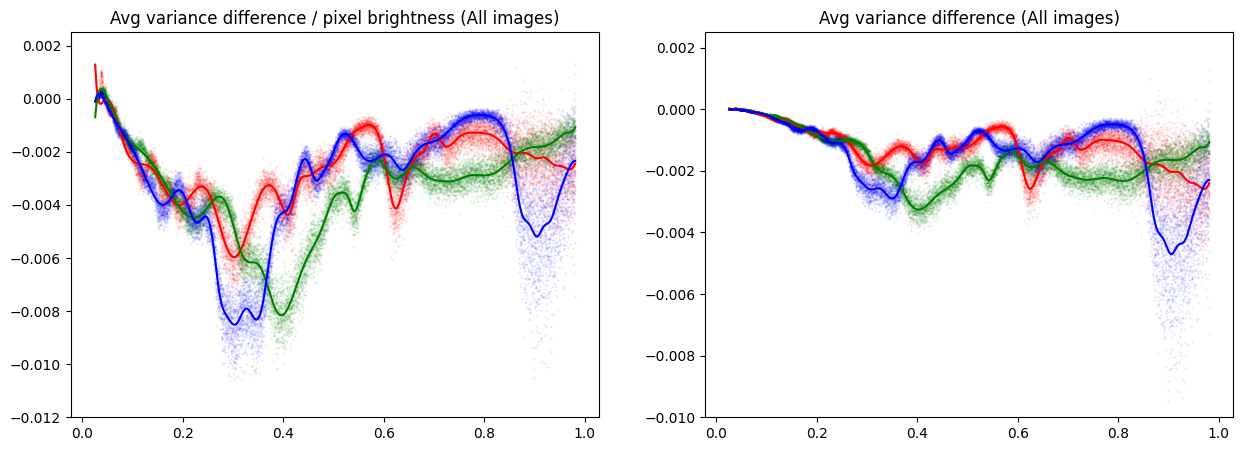

In [177]:
# Plot the original data and the fitted curve
fig, ax = plt.subplots(1,2, figsize=(15,5))
x_fit = np.linspace(smoothed_y_r[:,0].min(), smoothed_y_r[:,0].max(), 400)
y_fit_r = spline_r(x_fit)
y_fit_g1 = spline_g1(x_fit)
y_fit_b = spline_b(x_fit)
y_fit_g2 = spline_g2(x_fit)
ax[0].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1]/avg_y_per_x_r[:,0], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[0].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1]/avg_y_per_x_g1[:,0], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[0].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1]/avg_y_per_x_b[:,0], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[0].plot(x_fit, y_fit_r/x_fit, color='red')
ax[0].plot(x_fit, y_fit_g1/x_fit, color='green')
ax[0].plot(x_fit, y_fit_b/x_fit, color='blue')
ax[0].set_title("Avg variance difference / pixel brightness (All images)")
ax[0].set_ylim(-0.012, 0.0025)
ax[1].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[1].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[1].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[1].plot(x_fit, y_fit_r, color='red')
ax[1].plot(x_fit, y_fit_g1, color='green')
ax[1].plot(x_fit, y_fit_b, color='blue')
ax[1].set_title("Avg variance difference (All images)")
ax[1].set_ylim(-0.01, 0.0025)
plt.show()
